In [219]:
import numpy as np
import pickle
import neuraltda.SimplicialComplex as sc
import matplotlib.pyplot as plt
import scipy.linalg as spla
%matplotlib inline
reload(sc)

<module 'neuraltda.SimplicialComplex' from '/Users/brad/GentnerLab/code/NeuralTDA/neuraltda/SimplicialComplex.pyc'>

In [10]:
resF = ['/Volumes/gentner/btheilma/experiments/B1075/phy041216/Pen01_Lft_AP300_ML700__Site03_Z2700__B1075_cat_P01_S03_1/20170127T183908Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site01_Z3000__B1235_cat_P02_S01_1/20170127T235347Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/20170127T202857Z-10.0-5.0-4.0-TotalTopology.pkl']

resF = ['/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site01_Z3000__B1235_cat_P02_S01_1/20170127T235347Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site03_Z3000__B1235_cat_P02_S03_1/20170128T005306Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site04_Z3800__B1235_cat_P02_S04_1/20170128T005334Z-10.0-5.0-4.0-TotalTopology.pkl']
for resfname in resF:
    with open(resfname, 'r') as fd:
        resDict = pickle.load(fd)
        print(resDict)
        ec = 0
        for ind, num in enumerate(resDict['raw']['bettis'][1][1:]):
            ec = ec + (-1)**ind * num
        print(ec)
        

{'raw': {'bettis': [11963, [1, 25, 779, 61, 0]]}}
-693
{'raw': {'bettis': [15765, [1, 11, 837, 1472, 0, 0, 0, 0, 0, 0]]}}
646
{'raw': {'bettis': [10170, [1, 34, 623, 113, 0]]}}
-476


In [3]:
resDict

{'raw': {'bettis': [488, [1, 150, 21, 0]]}}

In [12]:
E = dict()
E[3] = 1

In [13]:
E

{3: 1}

In [15]:
E=[[] for ind in range(4)]

In [16]:
E

[[], [], [], []]

In [341]:
def union(a, b):
    return list(set(a) | set(b))

def primaryFaces(Q):
    L = []
    d = len(Q)
    Q = list(Q)
    Q.extend(Q[:d-2])
    for ind in range(d):
        s = (Q[ind:ind+(d-1)])
        L.append(tuple(sorted(s)))
    return L

def simplicialChainGroups(maxsimps):
    maxdim = max([len(s) for s in maxsimps])
    E=[[] for ind in range(maxdim+2)]
    K = list(maxsimps)
    while(len(K) > 0):
        Q = K.pop(0)
        L = primaryFaces(Q)
        k = len(Q)-1
        K = union(K, L)
        E[k] = union(E[k], L)
        E[k+1] = union(E[k+1], {Q})
    for k in range(len(E)):
        E[k] = sorted(E[k])
    return E

def boundaryOperator(Q):
    sgn = 1
    c = dict()
    Ql = list(Q)
    for ind in range(len(Ql)):
        n = Ql.pop(ind)
        c[tuple(Ql)] = sgn
        Ql.insert(ind, n)
        sgn = -1*sgn
    return c

def canonicalCoordinates(c, K):
    v = np.zeros(len(K))
    for ind in range(len(K)):
        if c.has_key(K[ind]):
            v[ind] = c[K[ind]]
    return v

def boundaryOperatorMatrix(E):
    
    nmat = len(E)
    D = [[] for i in range(nmat)]
    for k in range(1, nmat):
        m = len(E[k-1])
        n = len(E[k])
        mat = np.zeros((m, n))
        for j in range(n):
            c = boundaryOperator(E[k][j])
            mat[:, j] = canonicalCoordinates(c, E[k-1])
            D[k-1] = mat
    return D

def laplacian(D, dim):
    
    Di = D[dim]
    Di1 = D[dim+1]
    return np.dot(Di.T, Di) + np.dot(Di1, Di1.T)

def expandBasis(mat, oldK, newK, oldKm1, newKm1):
    
    basSource = sorted(union(oldK, newK))
    basTarget = sorted(union(oldKm1, newKm1))
    for ind, b in enumerate(basSource):
        if b not in oldK:
            mat = np.insert(mat, ind, 0, axis=1)
    for ind, b in enumerate(basTarget):
        if b not in oldKm1:
            mat = np.insert(mat, ind, 0, axis=0)
    return mat

def expandBases(D1, D2, E1, E2):
    pass

def densityMatrices(D, beta_list):

    rhos = []
    for ind in range(len(D)-3):
        L = laplacian(D, ind)
        M = spla.expm(beta_list[ind]*L)
        M = M / np.trace(M)
        rhos.append(M)
    return rhos

def spectralEntropies(rhos):

    ents = []
    for ind in range(len(rhos)):
        v, w = np.linalg.eig(rhos[ind])
        ve = np.log(v)
        ent = -np.dot(v.T, ve)
        ents.append(ent)
    return ents

def stimSpaceGraph(E, D):
    ''' Takes a set of generators for the chain groups 
    and produces generators for the graph of the space
    '''
    E[0] = []
    Ec = [v for sl in E for v in sl]
    adj = np.zeros((len(Ec), len(Ec)))
    for k in range(1, len(E)-1):
        mat = np.array(D[k])
        lm1 = sum([len(E[i]) for i in range(k)])
        lm2 = lm1 + len(E[k])
        lm3 = sum([len(E[i]) for i in range(k+1)])
        lm4 = lm2 + len(E[k+1])
        adj[lm1:lm2, lm3:lm4] = np.abs(mat)
    adj = (adj + adj.T)
    return adj

def graphLaplacian(adj):
    
    D = np.diag(np.sum(adj, axis=0))
    L = D - adj
    return L

In [338]:
adj = stimSpaceGraph(E, D)
L = graphLaplacian(adj)

(113, 113)
(0, 15, 15, 89)
(15, 74)
(15, 89, 89, 110)
(74, 21)
(89, 110, 110, 113)
(21, 3)
(110, 113, 113, 113)
(0,)


In [342]:
E = simplicialChainGroups(sorted([(1,2,3)]))
D = boundaryOperatorMatrix(E)
adj = stimSpaceGraph(E,D)
print(adj)
L = graphLaplacian(adj)
print(L)

(7, 7)
(0, 3, 3, 6)
(3, 3)
(3, 6, 6, 7)
(3, 1)
(6, 7, 7, 7)
(0,)
[[ 0.  0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  1.  0.]
 [ 1.  1.  0.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  1.  1.  0.]]
[[ 2.  0.  0. -1. -1.  0.  0.]
 [ 0.  2.  0. -1.  0. -1.  0.]
 [ 0.  0.  2.  0. -1. -1.  0.]
 [-1. -1.  0.  3.  0.  0. -1.]
 [-1.  0. -1.  0.  3.  0. -1.]
 [ 0. -1. -1.  0.  0.  3. -1.]
 [ 0.  0.  0. -1. -1. -1.  3.]]


In [313]:
k=8
E[0] = []
lm1 = sum([len(E[i]) for i in range(k)])
lm2 = lm1 + len(E[k])
lm3 = sum([len(E[i]) for i in range(k+1)])
lm4 = lm2 + len(E[k+1])
print(lm1, lm2, lm3, lm4)

IndexError: list index out of range

In [304]:
len(E[5])

69

In [286]:
Ec = [v for sl in E for v in sl][1:]
len(Ec)
Ec

[(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (9, 10),
 (9, 11),
 (9, 12),
 (9, 

In [132]:
mat = np.array([[1,2],[3,4],[5,6]])
oldK = [(1,2), (2,3)]
oldKm1 = [(1,), (2,), (3,)]
newK = [(1,2), (2,3), (6, 7), (8,9)]
newKm1 = [(1,), (2,), (3,), (6,), (7,), (8,), (9,)]
expandBasis(mat, oldK, newK, oldKm1, newKm1)


array([[1, 2, 0, 0],
       [3, 4, 0, 0],
       [5, 6, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [134]:
E = simplicialChainGroups(sorted([(1,2), (3,4), (4,5), (1,4), (2,5)]), 1)
D = boundaryOperatorMatrix(E)
print(E)
print(D)

[[()], [(1,), (2,), (3,), (4,), (5,)], [(1, 2), (1, 4), (2, 5), (3, 4), (4, 5)]]
[array([[ 1.,  1.,  1.,  1.,  1.]]), array([[-1., -1.,  0.,  0.,  0.],
       [ 1.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  1., -1.],
       [ 0.,  0.,  1.,  0.,  1.]]), []]


In [328]:
n = np.random.rand(15, 1200)
n = (n > 0.97).astype(int)
maxSimpList = sorted(sc.BinaryToMaxSimplex(n, rDup=True))
%time E = simplicialChainGroups(maxSimpList)
D = boundaryOperatorMatrix(E)
L = laplacian(D, 2)
rhos = densityMatrices(D, np.ones(len(D)))
print(spectralEntropies(rhos))


CPU times: user 4.85 ms, sys: 68 µs, total: 4.92 ms
Wall time: 5.11 ms
[1.6645763804102462, (1.6828760763763169+2.6192647243666408e-32j), 2.3232141013680998]


In [238]:
rhos

[array([[ 0.06666667,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.06666667,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.06666667,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.06666667,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.06666667,
          0.        ,  0.        ,

array([ 87.,   2.,   2.,   1.,   3.,   3.,   4.,   4.,   3.,   3.,   3.,
         4.,   2.,   4.,   3.,   4.,   2.,   5.,   2.,   3.,   4.,   2.,
         4.,   3.,   2.,   3.,   4.,   4.,   2.,   4.,   2.,   3.,   5.,
         2.,   3.,   2.,   4.,   3.,   2.,   4.,   2.,   4.,   2.,   4.,
         1.,   3.,   6.,   5.,   2.,   3.,   3.,   5.,   3.,   3.,   4.,
         3.,   3.,   3.,   3.,   4.,   3.,   3.,   5.,   3.,   3.,   3.,
         2.,   1.,   3.,   4.,   2.,   1.,   2.,   3.,   1.,   3.,   2.,
         3.,   3.,   1.,   2.,   2.,   2.,   0.,   2.,   0.,   4.,   1.,
         2.,   1.,   0.,   2.,   2.,   1.,   3.,   2.,   3.,   2.,   4.,
        32.])

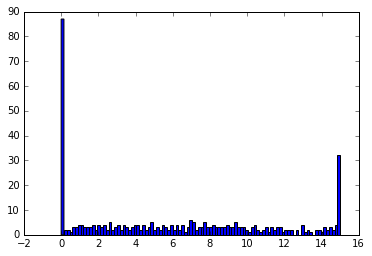

In [218]:
D = boundaryOperatorMatrix(E)
w, v = np.linalg.eig(laplacian(D, 2))
y, x, dontcare = plt.hist(np.real(w), 100)
y

In [102]:
c = boundaryOperator((1,2,3))
E = [(1,2), (1,3), (2,3), (4,5)]
canonicalCoordinates(c, E)

array([ 1., -1.,  1.,  0.])

In [52]:
set([1,2])

{1, 2}

In [55]:
set([]).union(*[[1,2], [2,3]])

{1, 2, 3}

In [57]:
tuple([[1,2],[3,4]])

([1, 2], [3, 4])

In [122]:
np.outer([-4, -2, 3], [1,3,1])

array([[ -4, -12,  -4],
       [ -2,  -6,  -2],
       [  3,   9,   3]])